In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd

### Leggo i dati

In [3]:
data = pd.read_csv("network.tsv", delimiter = '\t')
data = data.to_numpy()
data = data[ np.arange(len(data)) != (data[:,0] == "# Disease(MESH)").argmax() ]
data

array([['MESH:D005923', 'DB00564'],
       ['MESH:D009503', 'DB01072'],
       ['MESH:D016115', 'DB01759'],
       ...,
       ['MESH:D010518', 'DB04216'],
       ['MESH:D002653', 'DB02701'],
       ['MESH:D013119', 'DB04465']], dtype=object)

### Costruisco $B_{train}$ e $B_{test}$
Le matrici hanno $1$ in presenza di link e $-1$ in assenza. $B_{train}$ possiede inoltre degli elementi nulli che rappresentano i link incogniti

In [4]:
proporzione_train_test = 0.8

diseases  = np.unique(data[:,0])
chemicals = np.unique(data[:,1])

B_train = np.ones((len(diseases), len(chemicals))) * -1.
B_test  = np.ones((len(diseases), len(chemicals))) * -1.

print("Costruisco B_train e B_test")

for i,t in enumerate(data):
    if i % 10000 == 0:
        print( "%.2f %%" % (100 * (1. * i) / len(data)) )
    dis  = t[0]
    chem = t[1]

    idx_dis  = np.argmax(diseases == dis)
    idx_chem = np.argmax(chemicals == chem)
    B_test[idx_dis, idx_chem] = 1.
    B_train[idx_dis, idx_chem] = 1.

print("censuro alcune entries in B_train")

censor_mask = np.random.choice(2, size = B_train.shape , p = np.array([1 - proporzione_train_test, proporzione_train_test]))
B_train *= censor_mask

Costruisco B_train e B_test
0.00 %
2.14 %
4.29 %
6.43 %
8.57 %
10.71 %
12.86 %
15.00 %
17.14 %
19.29 %
21.43 %
23.57 %
25.71 %
27.86 %
30.00 %
32.14 %
34.29 %
36.43 %
38.57 %
40.72 %
42.86 %
45.00 %
47.14 %
49.29 %
51.43 %
53.57 %
55.72 %
57.86 %
60.00 %
62.14 %
64.29 %
66.43 %
68.57 %
70.72 %
72.86 %
75.00 %
77.14 %
79.29 %
81.43 %
83.57 %
85.72 %
87.86 %
90.00 %
92.14 %
94.29 %
96.43 %
98.57 %
censuro alcune entries in B_train


# Regression of probability

In [136]:
def predict(V,W, temp):
    VWT = jax.vmap(lambda v: jax.vmap(lambda w:  v @ w  )(W))(V)
    return jnp.tanh( temp * VWT )

def loss(V,W,B, temp = 1.):
    #                 annulla il test set                                media sugli elementi non nulli
    #                ,-------'------,                               ,-------'-------,
    return  jnp.sum( jnp.abs(B)        * (predict(V,W, temp) - B)**2 )  / jnp.abs(B).sum() 
loss = jax.jit(loss)
grad = jax.jit(jax.grad(loss, argnums = (0,1)))
m = 3
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
print(loss(V,W,B_train))

1.5263708


In [152]:
m = 100
np.random.seed(123)
V = np.random.randn(len(diseases), m)
W = np.random.randn(len(chemicals),m)
alfa = 10.
T = 1e-1
for i in range(500):
    T = (1. + 1e-3) * T
    G = grad(V,W,B_train, temp = T)
    newV = V - alfa * G[0]
    newW = W - alfa * G[1]
    if(loss(newV,newW,B_train) < loss(V,W,B_train)):
        alfa *= 1.1
        V = newV
        W = newW
    else:
        alfa *= 0.5
    if i % 20 == 0:
        print(loss(V,W,B_train), loss(V,W,B_test * (B_train == 0) ) )

1.9201386 1.9165978
1.919417 1.9164524
1.9144019 1.9154055
1.8595378 1.8884928
0.17603166 0.18705472
0.09506105 0.11369263
0.07919394 0.10637123
0.066905364 0.09844443
0.058114823 0.09385355
0.05141776 0.09065312
0.04448923 0.08857693
0.039416824 0.087977745
0.03509818 0.0876996
0.031125935 0.08774704
0.027476067 0.08758659
0.02464236 0.087946385
0.022526495 0.08798236
0.020501768 0.08832834
0.01918507 0.08852806
0.01830188 0.08861363
0.01767366 0.088813975
0.017158045 0.08903176
0.01667344 0.08916006
0.016278002 0.08933506
0.015983079 0.08945426


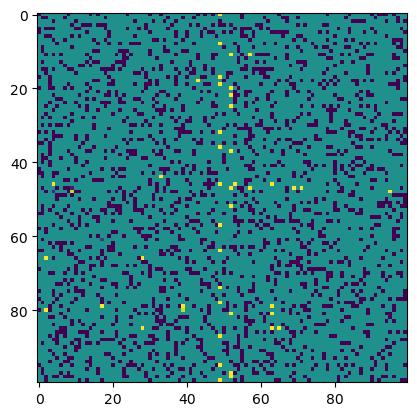

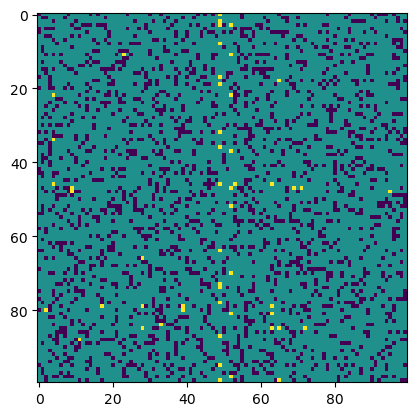

In [158]:
B_hat = predict(V,W,1.)
plt.imshow((B_hat * (B_train == 0.))[150:250,150:250] )
plt.figure()
plt.imshow((B_test * (B_train == 0.))[150:250,150:250] )

In [154]:
np.linalg.norm(B_hat - B_test), np.linalg.norm(B_train - B_test)

(529.7351, 1357.4590233226195)

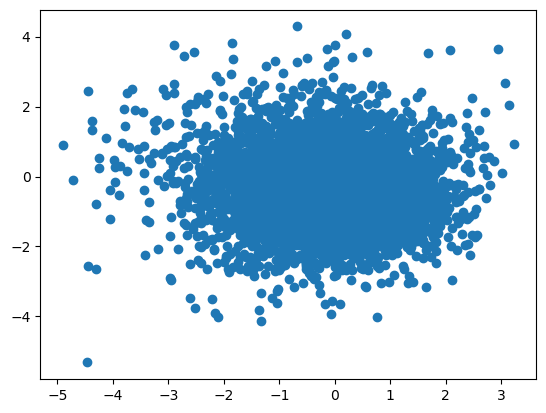

In [155]:
plt.scatter(V[:,0],V[:,1])